In [21]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from mmcv import Config
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.apis import single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset

import numpy as np
import pandas as pd
import os
import json

from PIL import Image

import torch
from metrics import find_best_metrics
import pickle

In [2]:
def gen_test_annotation(test_data_path, annotation_path):
    test_anno_list = []
    for img in os.listdir(test_data_path):
        if img.endswith('jpg'):
            img_info = {}
            img_info['filename'] = img
            img_size = Image.open(os.path.join(test_data_path, img)).size
            img_info['width'] = img_size[0]
            img_info['height'] = img_size[1]
            test_anno_list.append(img_info)
    with open(annotation_path, 'w+') as f:
        json.dump(test_anno_list, f)

In [3]:
!ls ../mmdetection/work_dirs/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco

20200530_200334.log			      epoch_13.pth  epoch_28.pth
20200530_200334.log.json		      epoch_14.pth  epoch_29.pth
20200530_200750.log			      epoch_15.pth  epoch_2.pth
20200530_200750.log.json		      epoch_16.pth  epoch_30.pth
20200530_201030.log			      epoch_17.pth  epoch_31.pth
20200530_201030.log.json		      epoch_18.pth  epoch_32.pth
20200530_201556.log			      epoch_19.pth  epoch_33.pth
20200530_201556.log.json		      epoch_1.pth   epoch_34.pth
20200530_201727.log			      epoch_20.pth  epoch_35.pth
20200530_201727.log.json		      epoch_21.pth  epoch_36.pth
20200530_201932.log			      epoch_22.pth  epoch_37.pth
20200530_201932.log.json		      epoch_23.pth  epoch_38.pth
cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco.py  epoch_24.pth  epoch_39.pth
epoch_10.pth				      epoch_25.pth  epoch_3.pth
epoch_11.pth				      epoch_26.pth  epoch_9.pth
epoch_12.pth				      epoch_27.pth  latest.pth


In [11]:
DATA_DIR = '/relevance2-nfs/chec/data/wheat'
#DIR_INPUT = '/kaggle/working/mmdetection/data/Wheatdetection'
DIR_TEST = f'{DATA_DIR}/test'
#DIR_ANNO = f'{DIR_INPUT}/annotations'

#DIR_WEIGHTS = '/kaggle/input/mmdetfasterrcnn'
WEIGHTS_FILE = '../mmdetection/work_dirs/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco/epoch_23.pth'

test_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

# prepare test data annotations
#gen_test_annotation(DIR_TEST, './detection_test.json')

In [5]:
!ls

5folds			 kregion		__pycache__
check_mmdet_preds.ipynb  metrics.py
detection_test.json	 mmdet inference.ipynb


In [47]:
config_file = '../mmdetection/configs/wheat/cascade_rcnn_r101_fpn_dconv_c3-c5_1x_coco.py'
cfg = Config.fromfile(config_file)
#cfg.data.val.test_mode = True

distributed = False

In [48]:
cfg.data.val

{'type': 'WheatDataset',
 'ann_file': 'val',
 'img_prefix': '/relevance2-nfs/chec/data/wheat/train/',
 'pipeline': [{'type': 'LoadImageFromFile'},
  {'type': 'LoadAnnotations', 'with_bbox': True},
  {'type': 'RandomFlip', 'flip_ratio': 0.0},
  {'type': 'Normalize',
   'mean': [123.675, 116.28, 103.53],
   'std': [58.395, 57.12, 57.375],
   'to_rgb': True},
  {'type': 'DefaultFormatBundle'},
  {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels']}]}

In [49]:
dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=1,
    dist=distributed,
    shuffle=False)

/home/core/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


>>>>>>> 685 val
>>>>>>> 685 val


In [50]:
cfg.model['pretrained'] = None

In [51]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)

print('loading my checkpoint...')
checkpoint = load_checkpoint(model, WEIGHTS_FILE, map_location='cpu')

#model.CLASSES = dataset.CLASSES

model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, False, None, 0.5)


loading my checkpoint...
>>>>>>> 685 val
[                                                  ] 0/685, elapsed: 0s, ETA:>>>>>>> 685 val


TypeError: imgs must be a list, but got <class 'torch.Tensor'>

In [15]:

results = []

for images_info, result in zip(dataset.data_infos, outputs):
    boxes = result[1][:, :4]
    scores = result[1][:, 4]

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    indexes = np.where(scores>0.44)
    #print(indexes)
    #print(labels)
    pred_boxes = boxes[indexes]
    scores = scores[indexes]

    result = {
        'image_id': images_info['filename'][:-4],
        #'PredictionString': format_prediction_string(boxes, scores),
        'boxes': pred_boxes
    }

    results.append(result)

loading my checkpoint...
>>>>>>> 685 val
[                                                  ] 0/685, elapsed: 0s, ETA:>>>>>>> 685 val
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 685/685, 10.4 task/s, elapsed: 66s, ETA:     0s

In [16]:
len(outputs)

685

In [29]:
outputs[0][1]

array([[7.99328003e+02, 3.51439972e+02, 8.89028198e+02, 4.71158417e+02,
        9.75345492e-01],
       [9.17815491e+02, 0.00000000e+00, 1.02058453e+03, 3.67414513e+01,
        9.72684145e-01],
       [2.35086441e+00, 3.79001617e+02, 7.73117981e+01, 4.36316071e+02,
        9.56486344e-01],
       [8.05812622e+02, 8.80326477e+02, 8.94627441e+02, 9.55529724e+02,
        9.46810126e-01],
       [8.61789612e+02, 2.99612457e+02, 9.56154602e+02, 3.54329559e+02,
        9.46257651e-01],
       [2.39987640e+02, 7.01253174e+02, 3.29834991e+02, 7.45354858e+02,
        9.40866411e-01],
       [3.46534912e+02, 7.10485474e+02, 4.35954407e+02, 7.58327148e+02,
        9.38533425e-01],
       [7.10150146e+02, 9.61675171e+02, 7.99428589e+02, 1.02400000e+03,
        9.37768698e-01],
       [7.56960388e+02, 1.70722446e+01, 8.38578308e+02, 6.37559052e+01,
        9.33186114e-01],
       [5.25349854e+02, 8.61084167e+02, 5.81445435e+02, 9.19601135e+02,
        9.27823305e-01],
       [4.57726196e+02, 9.0602

In [22]:
anns = pickle.load(open('../mmdetection/val_ann_2.pkl', 'rb'))

In [24]:
def get_all_preds(preds, anns):
    all_preds = []
    for p, gt in zip(preds, anns):
        det = {
            'pred_boxes': (p[1][:, :4]).clip(min=0, max=1023).astype(int),
            'scores': p[1][:, 4].astype(np.float32),
            'gt_boxes': gt['ann']['bboxes'],
            'image_id': gt['filename'],
            'labels': gt['ann']['labels'],
            'source': 'arvalis_1'
        }
        all_preds.append(det)
    return all_preds

In [30]:
all_preds = get_all_preds(outputs, anns)

In [27]:
all_preds[0]

{'pred_boxes': array([[799, 351,  89, 119],
        [917,   0, 102,  36],
        [  2, 379,  74,  57],
        [805, 880,  88,  75],
        [861, 299,  94,  54],
        [239, 701,  89,  44],
        [346, 710,  89,  47],
        [710, 961,  89,  62],
        [756,  17,  81,  46],
        [525, 861,  56,  58],
        [457, 906,  53,  82],
        [942,  39,  79,  43],
        [109, 814,  58,  64],
        [815, 717, 121,  51],
        [ 70, 197,  66,  69],
        [597, 262,  71,  48],
        [348, 778, 114,  45],
        [ 74, 769,  72,  44],
        [712,  86,  67,  46],
        [497, 183,  85,  50],
        [359, 829,  76,  63],
        [301, 860,  58,  64],
        [ 26, 150,  36,  48],
        [125, 908,  42,  72],
        [228, 972,  60,  51],
        [ 82, 671,  52,  36],
        [225, 214,  64,  38],
        [279,  66,  46,  49],
        [636, 760,  72,  59],
        [827, 649,  80,  46],
        [669, 251,  84,  54],
        [323,   4,  44,  49],
        [356, 665,  50,  3

In [31]:
find_best_metrics(all_preds)

{'best_score': 0.70536,
 'best_threshold': 0.47,
 0.3: 0.69999,
 0.37: 0.70284,
 0.4: 0.70385,
 0.42: 0.70439,
 0.45: 0.70533,
 0.5: 0.7046,
 0.55: 0.70349,
 0.6: 0.70216}

In [22]:
import matplotlib.pyplot as plt
import cv2
DATA_DIR = '/relevance2-nfs/chec/data/wheat'

In [23]:
def get_img_bboxes(preds, idx):
    image_id = preds[idx]['image_id']
    fn = f'{DATA_DIR}/test/{image_id}.jpg'
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = preds[idx]['boxes']
    
    return img, bboxes

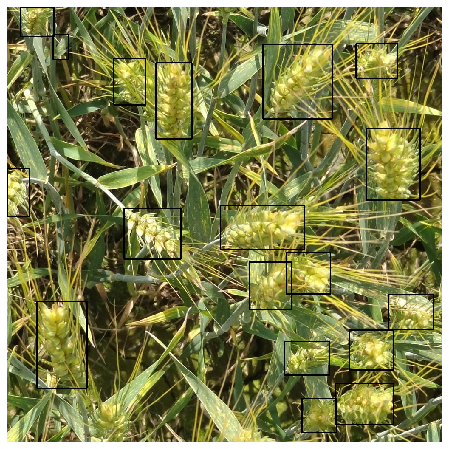

In [26]:
numpy_image, boxes = get_img_bboxes(results, 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2]+box[0],  box[1]+box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);